Exercise 2 - 
a)Compute the discrete derivative components in the motion gradient constraint equation for a single pixel location of a moving image, I(x, y, t). <br>
b)Compute the matrix A and vector b representing the motion constraint equations over a (small) n x n window centered on pixel (x, y). <br>
c)Solve the constraint equations either directly using the formula in the lecture slides or using a least-squares solver to estimate motion (u, v) at point (x, y). <br>
d)Estimate the motion for an grid of locations covering the image. <br>
e)Plot this optical flow field. Compare these results with those in first exercise. <br>

## Gradient Constraint Equation Method

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from IPython.display import HTML

In [9]:
def plotflow(I, X, Y, U, V, scale=1, threshold=-1):
    '''
    I - Image
    X, Y - Set the location of the arrows
    U, V - Arrow data
    '''
    fig, ax = plt.subplots(figsize=(10, 10), dpi=80)
    if threshold > 0:
        mask = np.abs(U + 1j*V) > threshold
        X = X[mask]
        Y = Y[mask]
        U = U[mask]
        V = V[mask]
    
    ax.imshow(I, cmap='gray')
    #Plots the 2D field of arrows
    ax.quiver(X, Y, U*scale, V*scale, color='red', angles='xy', scale_units='xy', scale=1)
    ax.set_aspect('equal')
    plt.show()
    
seq1 = {'I1': io.imread('../data/image/seq1/frame1.png', as_grey=True), 
        'I2': io.imread('../data/image/seq1/frame5.png', as_grey=True),
        'U' : np.loadtxt('../data/flow/seq1/flow3.u', dtype='double', delimiter=','),
        'V' : np.loadtxt('../data/flow/seq1/flow3.v', dtype='double', delimiter=',')}

rubic = {'I1':io.imread('../data/rubic/rubic.0.png', as_grey=True), 
         'I2':io.imread('../data/rubic/rubic.5.png', as_grey=True)}

sphere= {'I1': io.imread('../data/sphere/sphere.1.png', as_grey=True), 
         'I2': io.imread('../data/sphere/sphere.3.png', as_grey=True)}

sphere2 = {'I1': io.imread('../data/sphere/sphere.1.png', as_grey=True),
           'I2': io.imread('../data/sphere/sphere.5.png', as_grey=True)}



I = np.random.randint(0, 255, (128, 128))
#print(I)
synth = {'I1': I[0:100, 0:100],
         'I2': I[27:127, 27:127]}   

In [10]:
'''
I1 - current image
I2 - Image after time t
x, y - the point at which the gradient is being computed
'''
def compute_gradient_xyt(I1, I2, x, y):
    h, w = I1.shape
    x = int(x)
    y = int(y)
    
    if (x > 0 and x < w-1 and y >= 0 and y < h):
        Ix = (I1[y, x+1] - I1[y, x-1]) / 2
    else:
        Ix = 0
        
    if x >= 0 and x < w and y > 0 and y < h-1:
        Iy = (I1[y+1, x] - I1[y-1, x]) / 2
    else:
        Iy = 0
        
    if x >= 0 and x < w and y >= 0 and y < h:
        It = I2[y, x] - I1[y, x]
    else:
        It = 0
        
    return (Ix, Iy, It)    

In [11]:
#Computing the matrices A and b
def getAb(I1, I2, x, y, n):
    A = np.zeros((n*n, 2))
    b = np.zeros(n*n)
    
    # compute the relative positions of pixels in a window
    offset = np.arange(0, n) - np.floor(n/2)
    dx, dy = np.meshgrid(offset, offset)
    dx = dx.reshape(n*n, 1)
    dy = dy.reshape(n*n, 1)
    
    for i in range(0, n*n):
        Ix, Iy, It = compute_gradient_xyt(I1, I2, x+dx[i], y+dy[i])
        A[i, 0] = Ix
        A[i, 1] = Iy
        b[i] = -It
    
    return (A, b)

In [12]:
def estimate_flow_at_xy(I1, I2, x, y, n):
    A, b = getAb(I1, I2, x, y, n)
    
    result = np.linalg.lstsq(np.matmul(A.T, A), np.matmul(A.T, b))
    v = result[0]
    return v

In [13]:
# Estimate the optical flow field
def estimate_flow(I1, I2, gridX, gridY, n):
    H, W = gridX.shape
    U = np.zeros((H, W))
    V = np.zeros((H, W))
    
    #iterate over the grid
    for i in range(0, H):
        for j in range(0, W):
            v = estimate_flow_at_xy(I1, I2, gridX[i, j], gridY[i, j], n)
            U[i, j] = v[0]
            V[i, j] = v[1]
    return (U, V)        

In [25]:
def test_estimate_flow(seq):
    H, W = seq['I1'].shape
    gridsz = 9
    wsz = 21
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2)
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2)
    gridX, gridY = np.meshgrid(x, y)
    U, V = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    plotflow(seq['I1'], gridX, gridY, U, V, 3, 0.3)

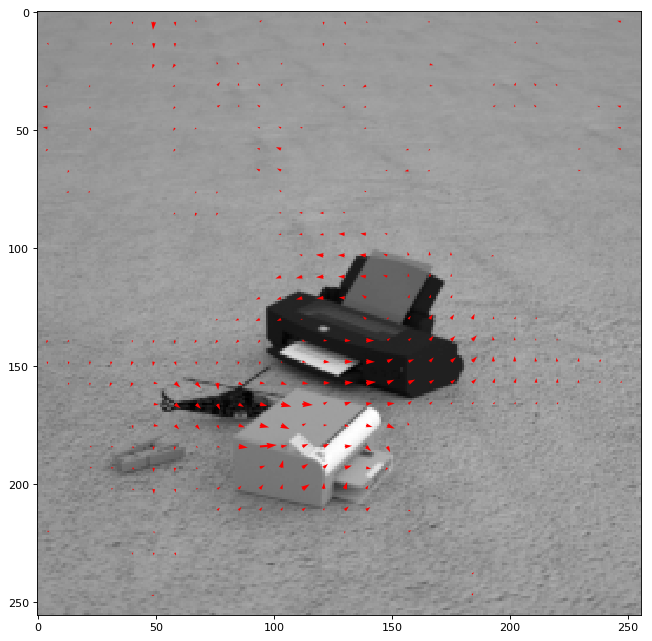

In [32]:
test_estimate_flow(seq1)
HTML('<img src="../data/image/seq1/gif_seq1.gif">')

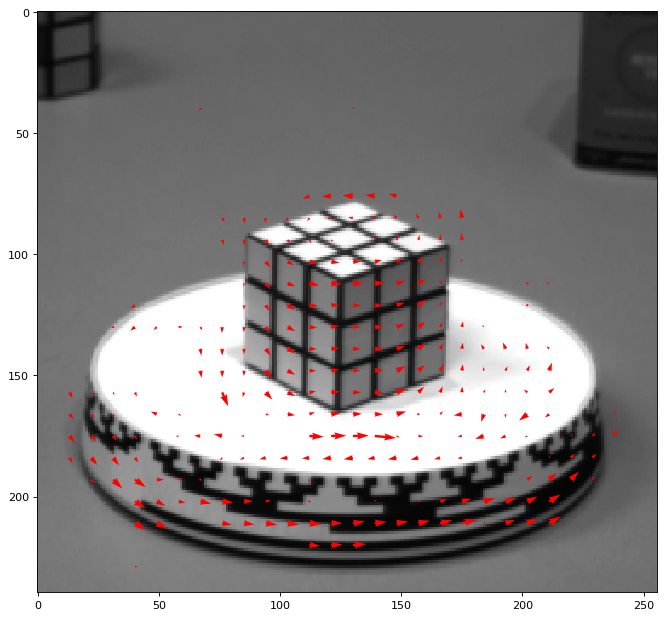

In [36]:
test_estimate_flow(rubic)
HTML('<img src="../data/rubic/rubic_gif.gif">')

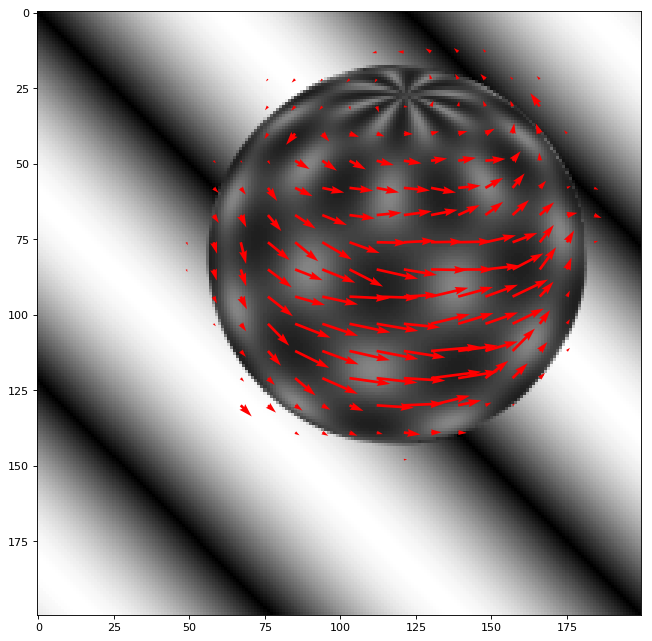

In [37]:
test_estimate_flow(sphere)
HTML('<img src="../data/sphere/sphere_gif.gif">')

In [39]:
#Making the grid size even smaller
def test_estimate_flow(seq):
    H, W = seq['I1'].shape
    gridsz = 5
    wsz = 21
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2)
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2)
    gridX, gridY = np.meshgrid(x, y)
    U, V = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    plotflow(seq['I1'], gridX, gridY, U, V, 3, 0.3)

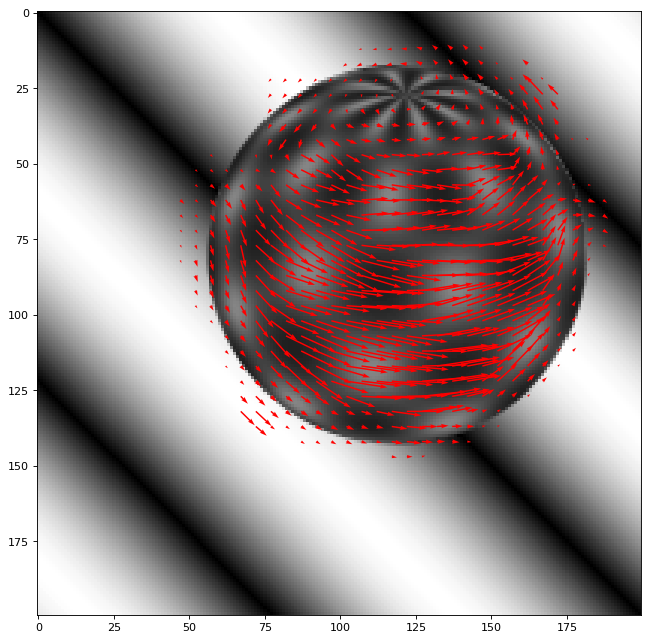

In [40]:
test_estimate_flow(sphere)

In [45]:
#Making the grid size even smaller
def test_estimate_flow(seq):
    H, W = seq['I1'].shape
    gridsz = 5
    wsz = 17
    x = np.arange(0, W-gridsz, gridsz) + np.floor(gridsz/2)
    y = np.arange(0, H-gridsz, gridsz) + np.floor(gridsz/2)
    gridX, gridY = np.meshgrid(x, y)
    U, V = estimate_flow(seq["I1"], seq["I2"], gridX, gridY, wsz)
    plotflow(seq['I1'], gridX, gridY, U, V, 3, 0.3)

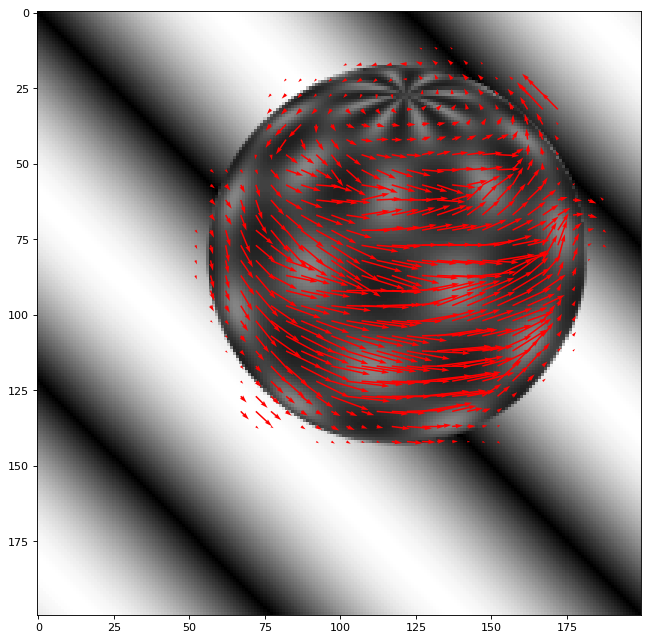

In [46]:
test_estimate_flow(sphere)

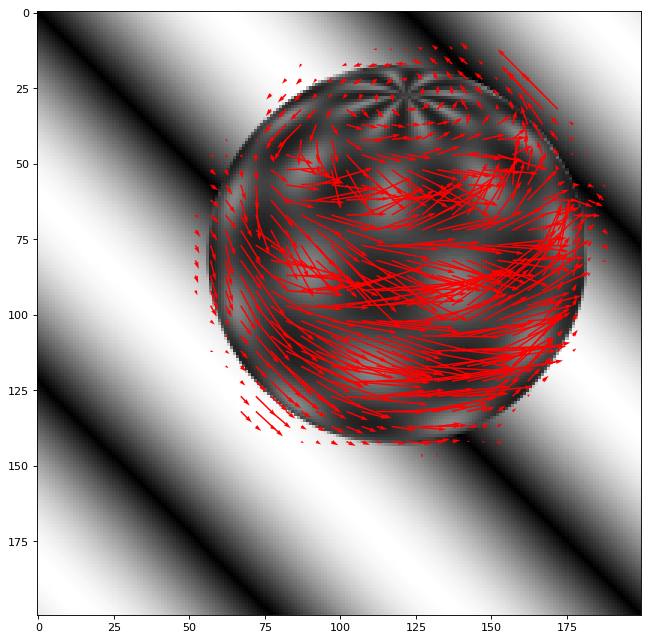

In [47]:
test_estimate_flow(sphere2)

Compared to the other method, The gradient constraint based motion estimation provides accurate results. 